# Crop Demand Forecasting

Forecast `Market_Demand` using features `Year, Month, Region, Crop` from `crop_demand_data.csv`.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')


In [4]:
# Load dataset
path_demand = os.path.join('..', 'datasets', 'crop_demand_data.csv')
demand = pd.read_csv(path_demand)

In [5]:
# Normalize and sort
demand['Crop'] = demand['Crop'].astype(str).str.strip().str.capitalize()
demand['Month'] = pd.to_numeric(demand['Month'], errors='coerce').fillna(1).astype(int)
demand['Year'] = demand['Year'].astype(int)
demand['date'] = pd.to_datetime(dict(year=demand['Year'], month=demand['Month'], day=1))
demand = demand.sort_values('date').reset_index(drop=True)

In [6]:
# Split by time
cutoff_date = demand['date'].quantile(0.8)
train_df = demand[demand['date'] <= cutoff_date].copy()
valid_df = demand[demand['date'] > cutoff_date].copy()

feature_cols = ['Year', 'Month', 'Region', 'Crop']
target_col = 'Market_Demand'

In [7]:
X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_valid = valid_df[feature_cols]
y_valid = valid_df[target_col]

In [8]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Region', 'Crop']),
    ('num', StandardScaler(), ['Year', 'Month'])
])

In [9]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
}

In [10]:
results = {}
for name, model in models.items():
    pipe = Pipeline([('prep', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_valid)
    results[name] = {
        'MAE': mean_absolute_error(y_valid, pred),
        'R2': r2_score(y_valid, pred),
        'pipeline': pipe
    }

print('Validation metrics:')
for n, r in results.items():
    print(f"{n}: MAE={r['MAE']:.2f}, R2={r['R2']:.3f}")

best_name = min(results, key=lambda k: results[k]['MAE'])
best_pipe = results[best_name]['pipeline']
print('Best model:', best_name)

Validation metrics:
LinearRegression: MAE=763.32, R2=0.407
RandomForestRegressor: MAE=95.80, R2=0.976
Best model: RandomForestRegressor


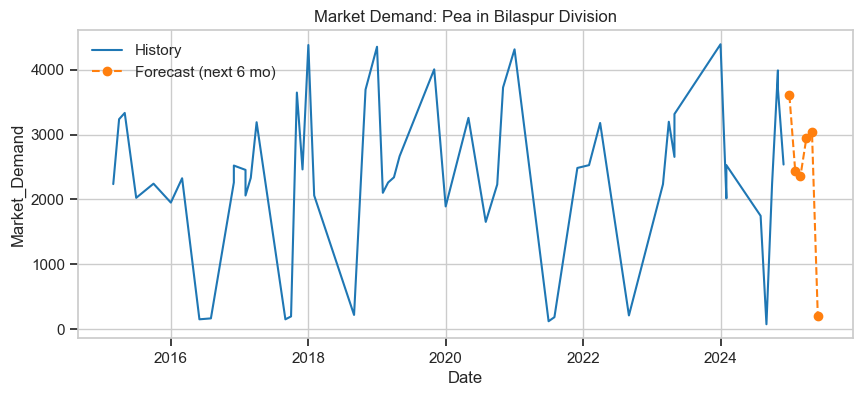

In [11]:
# 6-month forecast for the most frequent (Region, Crop)
from collections import Counter
pair_counts = Counter(list(zip(demand['Region'], demand['Crop'])))
(region_top, crop_top), _ = pair_counts.most_common(1)[0]

subset = demand[(demand['Region'] == region_top) & (demand['Crop'] == crop_top)].sort_values('date')
last_row = subset.iloc[-1]
last_year, last_month = int(last_row['Year']), int(last_row['Month'])

future_rows = []
for i in range(1, 7):
    month = last_month + i
    year = last_year + (month - 1) // 12
    month = ((month - 1) % 12) + 1
    future_rows.append({'Year': year, 'Month': month, 'Region': region_top, 'Crop': crop_top})

future_df = pd.DataFrame(future_rows)
future_df['date'] = pd.to_datetime(dict(year=future_df['Year'], month=future_df['Month'], day=1))
future_pred = best_pipe.predict(future_df[['Year', 'Month', 'Region', 'Crop']])

plt.figure(figsize=(10,4))
plt.plot(subset['date'], subset['Market_Demand'], label='History')
plt.plot(future_df['date'], future_pred, 'o--', label='Forecast (next 6 mo)')
plt.title(f'Market Demand: {crop_top} in {region_top}')
plt.xlabel('Date')
plt.ylabel('Market_Demand')
plt.legend()
plt.show()